<a href="https://colab.research.google.com/github/ratral/colab_control_valves/blob/master/cValvesCurator_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.- Installing an R Packages and functions.

_Read libraries_

In [23]:
requiredPackages <- c( "tidyverse", "here", "devtools", "scales", "gridExtra",
                       "knitr","kableExtra", "IRdisplay", "latex2exp")

  for(p in requiredPackages){
    if(!require( p, character.only = TRUE)) install.packages(p)
    library( p, character.only = TRUE)
  }


_Read hydraulic and valves functions_

In [24]:
  devtools::install_github( "ratral/wcontrolvalve")


Skipping install of 'wcontrolvalve' from a github remote, the SHA1 (4a5e316f) has not changed since last install.
  Use `force = TRUE` to force installation



In [25]:
# Define plot functions
  # CALCULATION Valve factors
    valve_parameters <- function(valve, dn, d1, d2){
      valve <- valve %>% 
        mutate( kvs  = wcontrolvalve::kv_value(dn, zvs)) %>% 
        mutate( fps  = wcontrolvalve::fp(kvs, dn, d1, d2)) %>% 
        mutate( flps = wcontrolvalve::flp(kvs, fls, dn, d1, d2)) %>% 
        mutate( flps_fps = flps/fps) %>% 
        select( name, kv_b, kv_d, kv_e, kvs, zvs,  fls, fps, flps, flps_fps)
      return(valve)
    }

  # CALCULATION 
    calc_data_analyse <- function(base_data, valve){
      base_data <- base_data %>% 
                   mutate( dp = (p1 - p2), 
                           kv = wcontrolvalve::kv(p1, p2, flow, temp)) %>% 
                   mutate( zeta  = wcontrolvalve::zeta_vaule(dn, kv),
                           sig_1 = wcontrolvalve::sigma_1(p1, p2, elev, temp)) 
  
      data_analyse <- valve %>% 
                      mutate(data = list(base_data)) %>% unnest(data) %>% 
                      mutate(kv_kvs = ifelse(kv > kvs, NA, kv/kvs), position = 0)
  
      for(i in c(1:length(data_analyse$kv_kvs))){
        if(is.na(data_analyse$kv_kvs[i])){
          data_analyse$position[i] <- NA
        } else {
          data_analyse$position[i] <- wcontrolvalve::inv_LL3(
            data_analyse$kv_kvs[i], data_analyse$kv_b[i],
            data_analyse$kv_d[i], data_analyse$kv_e[i])
       }
      }

      data_analyse <- data_analyse %>% 
          mutate( flp_fp = ifelse( kv > kvs, NA, wcontrolvalve::fl_function( position, kv_b, kv_d, kv_e, flps_fps)),
                Sig_i  = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_i( position, kv_b, kv_d, kv_e, flps_fps)),  # Incipient Cavitation
                Sig_c  = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_c( position, kv_b, kv_d, kv_e, flps_fps)),  # Constant Cavitation
                Sig_mv = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_mv( position, kv_b, kv_d, kv_e, flps_fps)), #  Maximum Vibration Cavitation
                regime = ifelse( kv > kvs, NA, wcontrolvalve::cavtation_regime(position, kv_b, kv_d, kv_e, flps_fps, sig_1)))

      data_analyse <- data_analyse %>%
        group_by(name, kv_b, kv_d, kv_e, zvs, kvs, fls, fps, flps, flps_fps) %>% 
        nest()

      return(data_analyse)
    }



  # TABLE with the parameter of the valves
  tab_param_valves <- function(valve){
    valve %>% select(name, kvs, zvs, fls, fps, flps, flps_fps) %>%  
    mutate( kvs = scales::comma(kvs)) %>%
    kbl(caption ="Parameter of the valves",
        col.names = c("name", "Kvs", "Zeta", "FLs", "Fps", "FLps", "FLps/Fps"),
        digits = c(0, 0, 3, 3, 3, 3, 3)) %>% 
    kable_classic( bootstrap_options = "striped", full_width = F, position = "left")  %>%
    column_spec(column = 1:7, width = "0.6in")  %>%
    as.character() %>%
    display_html()
  }


  # TABLE with the Parameter Points with for the dif. Valves
  tab_param_points <- function(data_analyse, i){
  
    data_analyse$data[[i]] %>% 
      select( measurement, p1, p2, dp, flow, kv, zeta, flp_fp, kv_kvs, 
              position,  sig_1, Sig_i, Sig_c, Sig_mv, regime) %>%
      mutate( flow = scales::comma(flow), kv   = scales::comma(kv),
              kv_kvs = scales::percent(kv_kvs), position = scales::percent(position/100)) %>%
      kbl( caption ="Parameter of the valves", 
           col.names = c( "Meas", "P1", "P2", "DP", "Flow", "Kv", "Zeta", "FLp/Fp",
                          "Kv/Kvs", "Position",  "Sigma", "Sigma_i", "Sigma_c", 
                          "Sigma_mv", "Regime"),
           digits = c(0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0)) %>%
      kable_classic( bootstrap_options = "striped", full_width = F, position = "left")  %>%
      column_spec(column = 1:14, width = "0.5in")  %>%
      column_spec(column = 15, width = "1.5in")  %>%
      as.character() %>%
      display_html()
  }
  
  # PLOT Kv/Kvs and points
  plot_kv_kvs2 <- function(data_analyse, i) {
    
    data_points <- data_analyse$data[[i]] %>% 
    select( position, kv_kvs) %>% 
    mutate( kv_kvs = kv_kvs * 100) %>% 
    rename( x = position, y = kv_kvs )
  
    plot_1 <- wcontrolvalve::plot_kv_kvs(  data_analyse[i,]$kv_b, data_analyse[i,]$kv_d, 
                data_analyse[i,]$kv_e, data_analyse[i,]$name) +
              geom_point(  data = data_points, aes( x = x, y = y ), 
                colour = "black", size = 2) +
              geom_segment( data = wcontrolvalve::segment_data(data_points), 
                      aes(x = x, y = y, xend = xend, yend = yend), 
                      linetype = "dotted")
  return(plot_1)
  } 

  # PLOT Sigma values and points
  plot_sigma2 <- function(data_analyse, i){
 
    data_points <- data_analyse$data[[i]] %>% 
      select( position, sig_1) %>% 
      rename( x = position, y = sig_1 )
  
    plot_1 <- wcontrolvalve::plot_sigma( data_analyse[i,]$kv_b, data_analyse[i,]$kv_d, 
              data_analyse[i,]$kv_e, data_analyse[i,]$flps_fps, 
              data_analyse[i,]$name) +
    geom_point( data = data_points, aes( y = y, x = x ), colour = "black", size = 2) +
    geom_segment(data = wcontrolvalve::segment_data(data_points), aes(x = x, y = y, xend = xend, yend = yend), linetype = "dotted")  

    return(plot_1)
  }

# 2.- The issue to be solved (Control Valve Selection)

The objective of this exercise is to select between three possible types of control valves (the same valve but different types of cylinders) the most suitable for the operation of the system.

The conditions are as follows:

  - the diameter of the valve is smaller than the diameter of the pipes;
  -  the system requires a constant flow,
  - the pressures upstream and downstream of the valve vary during the operation of the system;
  - Initially, only three operational points will be evaluated.

The steps to follow are those:

   - Step 1. Specify the data and variables required to size the valve.


## Step 1. Specify the data and variables required to size the valve.

### Basic data

In [22]:
  temp <- 15.00   # Upstream water temperature in centigrade (°C)
  elev <- 2700    # Elevation above sea level - in meter - 
  flow <- 9396    # Flow in m3/h
  dn   <- 1000    # Diameter of the valve in millimeter
  d1   <- 1400    # Diameter of the Pipe Upstream in millimeter
  d2   <- 1200    # Diameter of the Pipe Downstream in millimeter

### Minimum, mean, and maximum pressures upstream and downstream of the valve and flow. 

(Pressure in $bar$ and flow in $m^3/hr$)

In [21]:
  base_data <- tribble(
    ~measurement, ~p1,   ~p2, ~flow,
    "Min.",      1.720, 0.614,  9396,
    "Mean",      1.410, 0.684,  9396,
    "Max.",      1.370, 1.009,  9396
  ) 

### Flow characteristic curve of the valve (inherent flow characteristic of the valve).

  - parameters of the flow characteristic curve:
    - $b$ denoting the steepness of the low characteristic curve, 
    - $d$ is the upper asymptotes or limits of the response, and, 
    - $e$ is the effective dose. 
  - Loss Coefficient $(\zeta_{v_s})$ is the Zeta value of the valve by 100% opening.
  - $F_{L_s}$ is the Liquid Pressure Recovery Factor by 100%

In [20]:
  valve <- tribble(
    ~name,       ~kv_b, ~kv_d,   ~kv_e,   ~zvs,  ~fls,
    "valve_01", -2.393,	1.389,  67.422,	 1.780,	0.617, # 0
    "valve_02", -3.893,	1.146,  61.038,  3.000,	0.598, # 20-30
    "valve_03", -2.755, 1.979,  99.215, 15.830, 0.775  # 40
  ) 
  

## Step 2. Calculation $ K_{v_s}$, $F_{P_s}$ and $F_{LP_s}$ 

- Flow coefficient by 100% opening : $ K_{v_s} = \frac{d^2}{\sqrt{626.3}} \cdot \frac{1}{\sqrt{\zeta_{v_s}}}$

- Piping geometry factor by 100% opening : $F_{P_s} = \frac{1}{\sqrt{1+\frac{\sum{\zeta} \cdot \left(\frac{K_{v_s}}{d^2} \right)^2}{0.0016}}}$

- Combined liquid pressure recovery factor: $F_{LP_s} = \frac{F_{L_s}}{\sqrt{1 + F_{L_s} \cdot \frac{\sum{\zeta} \cdot \left(\frac{K_{v_s}}{d^2} \right)^2}{0.0016}}}$ 

In this equations, the factor $\sum \zeta$ is the algebraic sum of all effective resistance coefficients of all fittings that are attached to the control valve. This does not include the drag coefficient of the control valve itself.

$ \sum{\zeta} = (\zeta_{1} + \zeta_{2}) + (\zeta_{B_1} - \zeta_{B_2})$


Where:

  - $\zeta_1$ is the resistance coefficient of the valve in the inlet : $\zeta_1 = 0.5 \cdot \left( 1 - \left( \frac{d}{D_1}\right)^2 \right)^2$
  - $\zeta_{2}$ is the resistance coefficient of the valve in the outlet : $\zeta_2 = \left( 1 - \left( \frac{d}{D_2}\right)^2 \right)^2$
  - $\zeta_{B_1}$  is the Bernoulli pressure number in the valve inlet : $\zeta_{B_1} = 1- \left( \frac{d}{D_1}  \right)^4$
  - $\zeta_{B_2}$  is the Bernoulli pressure number in the valve outlet :$\zeta_{B_2} = 1- \left( \frac{d}{D_2}  \right)^4$







In [19]:
  valve <- valve_parameters(valve, dn, d1, d2)
  valve %>% tab_param_valves ()

name,Kvs,Zeta,FLs,Fps,FLps,FLps/Fps
valve_01,"29,950",1.78,0.617,0.897,0.590,0.658
valve_02,"23,070",3.00,0.598,0.935,0.583,0.624
valve_03,"10,043",15.83,0.775,0.987,0.769,0.779


## Step 3. Calculation of the $K_v$, $\zeta_{v}$ and $\sigma$ for the valve and data.

  - Flow coefficient: $ K_v = q \cdot \sqrt{\frac {(\rho / \rho_{0})}{\Delta P}}$
    - $K_v$: Flow ($m^3/h$) at $\Delta P = 1 \, bar$
    - $\Delta P$: operating pressure differential ($bar$); 
    - $q$: flow rate in ($m^3/h$); 
    - $\rho_{0}$: The specific mass of water at temperature 15.5 °C  (i.e. 1000 $kg/m^3$); 
    - $\rho$: The specific mass of water at the upstream temperature $T$ in ($kg/m^3$) ; 
    - $T$:  the upstream temperature. 

  - Loss Coefficient: $\zeta_{v} = {\frac{1}{626.3} \cdot  \bigg( {\frac{d^2}{{K_v}}}} \bigg)^2$
      - $\zeta_{v}$: dimensionless;
      - $d$: Valve nominal size in ($mm$).

  - Cavitation Index: $\sigma_{1} = \frac{P_2-P_v}{\Delta P_{net}}$ 
      - $\sigma$: dimensionless;
      - $P_2$: Upstream absolute pressure ($bar$);
      - $P_v$: vapor pressure ($bar$);
      - $\Delta P$: operating pressure differential ($bar$).
  - Cavitation coefficients:
      - $\sigma_{i}$: Coefficient of Incipient cavitation, 
      Separing **_Regime I_** and **_Regime II_**;
      - $\sigma_{c}$: Coefficient for constant cavitation, Separing **_Regime II_** and **_Regime III_**;
      - $\sigma_{mv}$: Coefficient of cavitation causing  maximum vibration (incipient damage), Separing **_Regime III_** and **_Regime IV_**.

- Regime:
  - Regime I: free of cavitation.
  - Regime II. (beginning with $\sigma_{i}$) :
    - Onset of cavitation
    - Detect using high frequency vibration measurement
    - Very local phenomenon
    - Transient: random “ticks” sound
    - Low level cavitation: usually not damaging
    - Occurs prior to loss of capacity
  - Regime III. (beginning with $\sigma_{c}$) :
    - More regular cavitation events
    - Lower frequency sound and vibration sensed: “rumbling” sound
    - Some damage to surfaces may occur: dependent upon valve and trim styles, and materials.
  - Regime IV. (beginning with $\sigma_{mv}$) :
    - Highest vibration amplitude: sounds like “marbles” or “gravel”
    - Vigorous, large scale cavitation
    - Predicted by the Liquid Pressure Recovery Factor ( $ \geq F_L$ )
    - Very high damage potential


In [8]:
  # Calculation of characteristics
    data_analyse <- calc_data_analyse(base_data, valve)

### print data from valve 01

In [9]:
tab_param_points(data_analyse, 1)

Meas,P1,P2,DP,Flow,Kv,Zeta,FLp/Fp,Kv/Kvs,Position,Sigma,Sigma_i,Sigma_c,Sigma_mv,Regime
Min.,1.72,0.61,1.11,"9,396","8,936",20.00,0.85,29.8%,39.2%,1.20,0.67,0.55,0.39,free of cavitation (regime I)
Mean,1.41,0.68,0.73,"9,396","11,029",13.13,0.82,36.8%,44.0%,1.93,0.83,0.68,0.48,free of cavitation (regime I)
Max.,1.37,1.01,0.36,"9,396","15,641",6.53,0.77,52.2%,54.6%,4.79,1.18,0.97,0.68,free of cavitation (regime I)


### print data from valve 02

In [10]:
tab_param_points(data_analyse, 2)

Meas,P1,P2,DP,Flow,Kv,Zeta,FLp/Fp,Kv/Kvs,Position,Sigma,Sigma_i,Sigma_c,Sigma_mv,Regime
Min.,1.72,0.61,1.11,"9,396","8,936",20.00,0.79,38.7%,51.4%,1.20,1.01,0.84,0.61,free of cavitation (regime I)
Mean,1.41,0.68,0.73,"9,396","11,029",13.13,0.76,47.8%,56.0%,1.93,1.25,1.04,0.75,free of cavitation (regime I)
Max.,1.37,1.01,0.36,"9,396","15,641",6.53,0.70,67.8%,67.1%,4.79,1.78,1.47,1.06,free of cavitation (regime I)


### print data from valve 03

In [11]:
tab_param_points(data_analyse, 3)

Meas,P1,P2,DP,Flow,Kv,Zeta,FLp/Fp,Kv/Kvs,Position,Sigma,Sigma_i,Sigma_c,Sigma_mv,Regime
Min.,1.72,0.61,1.11,"9,396","8,936",20.00,0.8,89%,92%,1.20,1.17,0.92,0.58,free of cavitation (regime I)
Mean,1.41,0.68,0.73,"9,396","11,029",13.13,NA,NA,NA,1.93,NA,NA,NA,NA
Max.,1.37,1.01,0.36,"9,396","15,641",6.53,NA,NA,NA,4.79,NA,NA,NA,NA


## Step 4. Plot of the $K_v$, $Z_v$ ans $\sigma$ for the valve and data.

### Standrd Curves of the Valves 

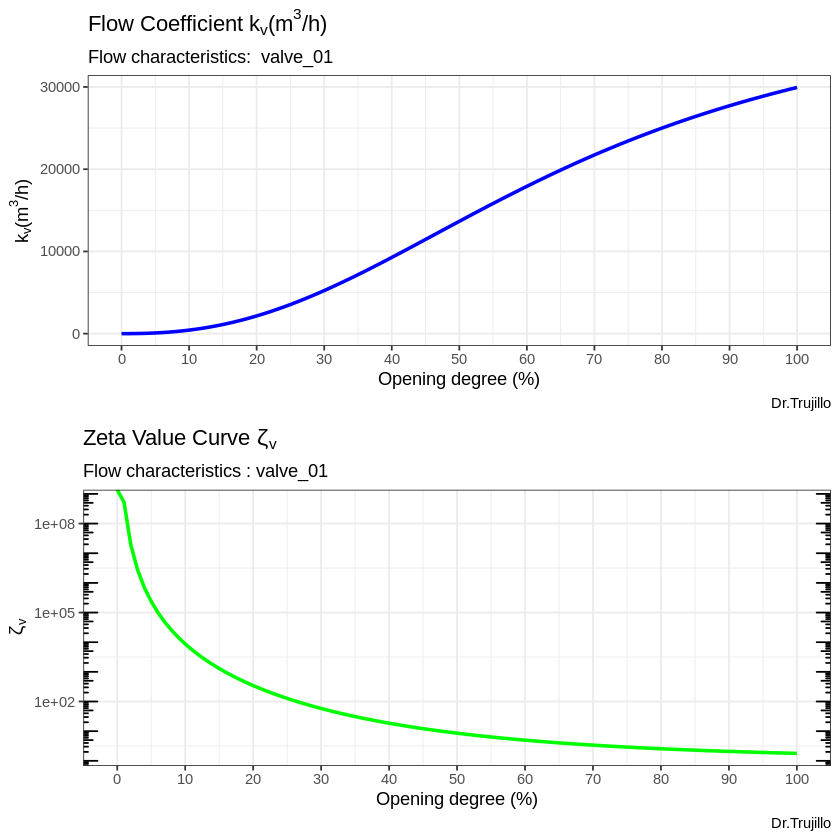

In [12]:
# Plot Kv/Kvs
  i <- 1
  p1 <- wcontrolvalve::plot_kv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], dn, valve$zvs[i], valve$name[i]) 
  p2 <- wcontrolvalve::plot_zv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], valve$zvs[i], valve$name[i])
  grid.arrange(p1, p2, nrow = 2)
  


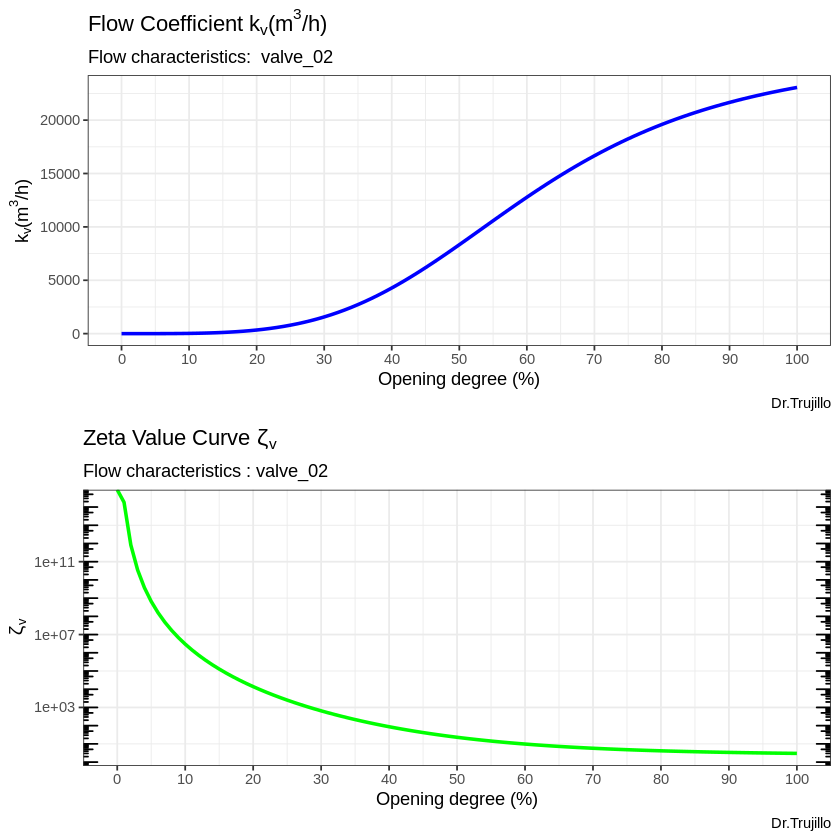

In [13]:
  i <- 2
  p1 <- wcontrolvalve::plot_kv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], dn, valve$zvs[i], valve$name[i]) 
  p2 <- wcontrolvalve::plot_zv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], valve$zvs[i], valve$name[i])
  grid.arrange(p1, p2, nrow = 2)
  

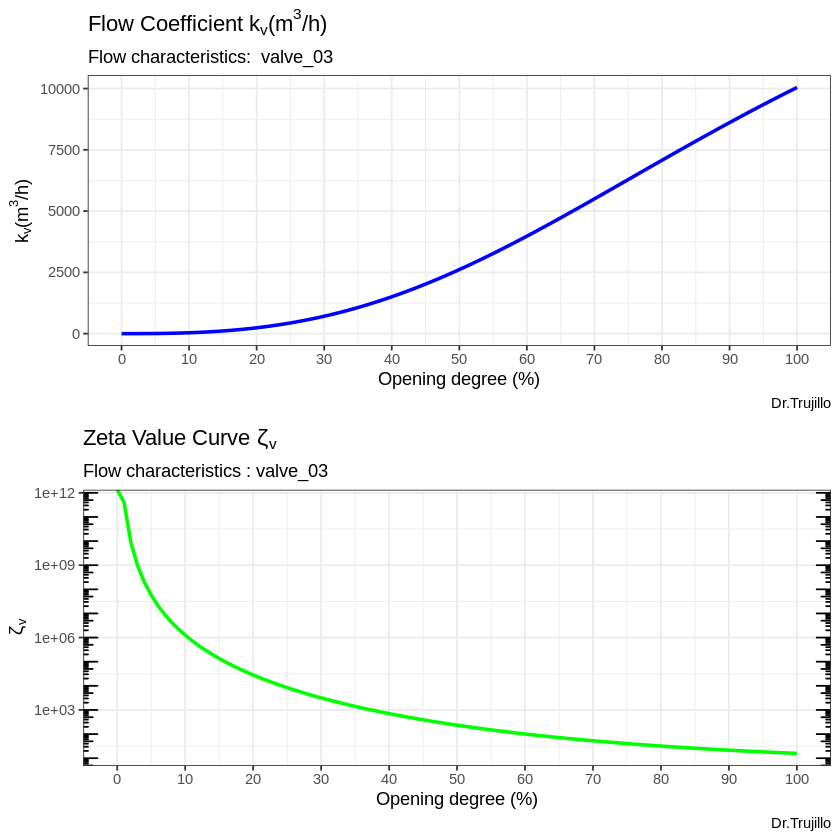

In [14]:
  i <- 3
  p1 <- wcontrolvalve::plot_kv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], dn, valve$zvs[i], valve$name[i]) 
  p2 <- wcontrolvalve::plot_zv(valve$kv_b[i], valve$kv_d[i], valve$kv_e[i], valve$zvs[i], valve$name[i])
  grid.arrange(p1, p2, nrow = 2)
  

###  Valve position, $k_v/k_{vs}$ and Sigma ($\sigma$) values

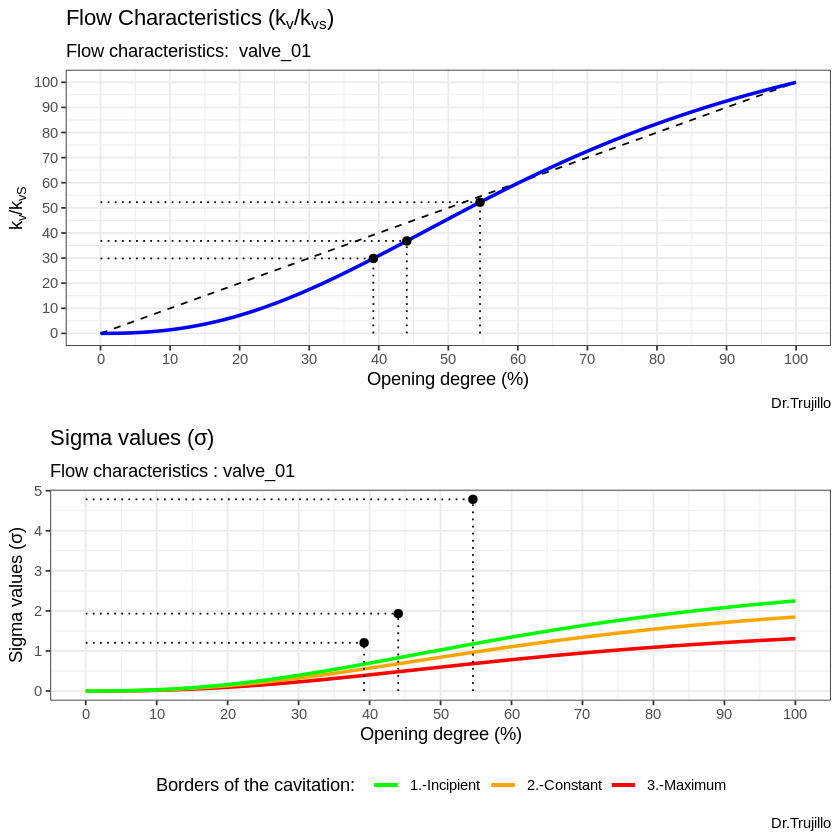

In [27]:
  i <- 1
  plot_01 <- plot_kv_kvs2(data_analyse, i)
  plot_02 <- plot_sigma2(data_analyse, i)
  grid.arrange(plot_01, plot_02, nrow = 2)

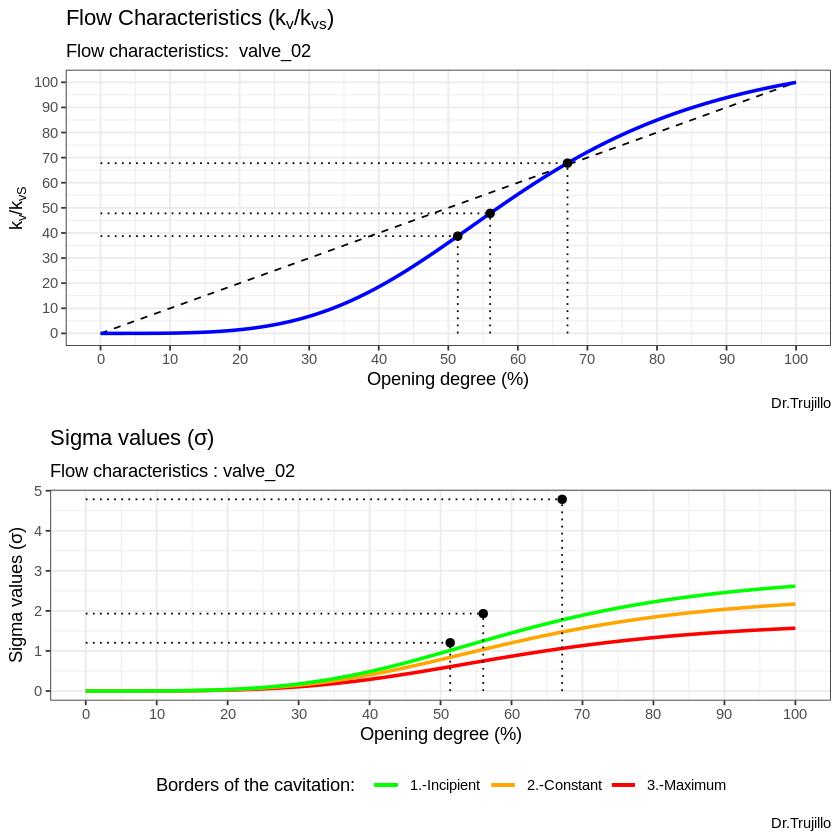

In [28]:
i <- 2
  plot_01 <- plot_kv_kvs2(data_analyse, i)
  plot_02 <- plot_sigma2(data_analyse, i)
  grid.arrange(plot_01, plot_02, nrow = 2)